# Import libraries

In [1]:
## general
import numpy as np
import pandas as pd
import xarray as xr
import copy
import numpy.ma as ma
from itertools import compress
import joblib
import os
import regionmask
import time 
import geopandas
import cftime
import datetime as dt
from tqdm import tqdm

## plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import from_levels_and_colors
from matplotlib.lines import Line2D 
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import mplotutils as mpu

## statistics
#from statsmodels.nonparametric.smoothers_lowess import lowess # lowess filter
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from joblib import Parallel,delayed

# extra stuff for Lea's loading codes
import glob

# Define functions

In [2]:
def norm_cos_wgt(lats):
    
    from numpy import cos, deg2rad
    
    return np.cos(np.deg2rad(lats))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
def combine_dims(a, start=0, count=2):
    """Reshapes numpy array a by combining count dimensions, 
    starting at the dimension index start"""
    
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start+count:])

In [4]:
def load_data_obs(obs, Tref_start='1951-01-01', Tref_end='1980-01-01', Tblendglob_idx=False):
    """ Load the observations.

    Keyword argument:
    - obs: currently implemented for "best" and "cowtan"
    - Tref_start: starting point for the reference period with default 1951 (ie BEST Tref)
    - Tref_end: last year still INCLUDED for the reference period with default 1980 (ie BEST Tref) (ATTENTION: different from load_data_single_mod where is the first NOT included)
    - Tblend_idx: whether to compute the blended Tanglob anomaly or not (default = False)

    Output:
    - y: the land grid points of the anomalies of the variable on grid centered over 0 longitude (like the srexgrid) 
    - time: the time slots
    - Tblendglob = area weighted global mean temperature (blend from SST over ocean and tas over land + sea ice)
        
            
    """
    dir_data = '/home/tristan/mesmer/data/'
    
    # read in the land-sea mask
    file_ls = 'interim_invariant_lsmask_regrid.nc' # ERA-interim mask regridded by Richard from 73x144 to 72x144
    frac_l = xr.open_mfdataset(dir_data+file_ls) #land-sea mask of ERA-interim bilinearily interpolated 
    frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

    lons, lats = np.meshgrid(frac_l.lon.values,frac_l.lat.values) # the lon, lat grid (just to derive weights)   
    wgt = norm_cos_wgt(lats) # area weights of each grid point
    
    
    if obs == 'best':
        obs_file='obs_data_25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+obs_file).rename({'temperature':'tas'}).sel(time=slice('1880-01-01', '2022-01-01'))
        time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        ds_obs['time'] = time
    
    if obs == 'giss':
        file='GISS_tas_g25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+file).rename({'tempanomaly':'tas'}).sel(time=slice('1880-01-01', '2022-01-01')).drop(['time_bnds'])
        time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        ds_obs['time'] = time
        ds_obs['lon'] = ds_obs['lon']-180
        
    T_ref = ds_obs.tas.sel(time=slice(Tref_start, Tref_end)).mean(dim='time')
    if Tblendglob_idx == True:
        tas=ds_obs.tas.values-T_ref.values
        Tblendglob=np.zeros(tas.shape[0])
        for t in np.arange(tas.shape[0]):
            idx_valid = ~np.isnan(tas[t])
            Tblendglob[t] = np.average(tas[t,idx_valid],weights=wgt[idx_valid]) #area weighted of available obs -> less data available at beginning        
    
    y=(ds_obs.tas.values-T_ref.values)[:,idx_l]
    time=ds_obs.time.values
    
    if Tblendglob_idx==True:
        return y,time,Tblendglob
    else:
        return y,time

In [5]:
def compute_wgt_reg_obs(reg):
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_obs = "obs_data_25.nc"
    file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
    file_srex_shape = "referenceRegions.shp"

    df_obs=xr.open_mfdataset(dir_data+file_obs)

    # SREX names ordered according to SREX mask
    srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 
        
    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land

    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    datasets = ["best", "giss"]
    
    obs_tas_mean = {}
    x = {}
    list_x = {}
    y_mon = {}
    y_ann = {}
    
    for dataset in datasets:
        obs_tas_mean[dataset] = {}
        if dataset == "giss":
            for i in np.arange(len(time_obs)):
                idx_valid=~np.isnan(tas_GISS[i][idx_reg_l])
                obs_tas_mean[dataset][i] = np.average(tas_GISS[i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid]) 
                
        if dataset == "best":
            for i in np.arange(len(time_obs)):
                idx_valid=~np.isnan(tas_BEST[i][idx_reg_l])
                obs_tas_mean[dataset][i] = np.average(tas_BEST[i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid])
                
        x[dataset] = obs_tas_mean[dataset].items()
        list_x[dataset] = list(x[dataset])
        y_mon[dataset] = np.array(list_x[dataset])[:, -1]
        y_ann[dataset] = pd.DataFrame({"time":time_obs, "tas":y_mon[dataset]}).set_index("time")
        y_ann[dataset] = y_ann[dataset].resample("Y").mean()
        
    time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[Y]')
    print('weighting complete')
    return y_mon, y_ann, time, idx_reg_l_grid

In [6]:
def compute_Tan_wgt_reg_emu(reg):
    
    """
    Computes the weighted averaged monthly and annual temperatures for global land, 
    or for a given SREX region.
    Inputs:
    - reg: region: can be 'Global_land', or any of the SREX regions
    - emulator_innovations: output file from the emulations (with lat lon gridded data)
    Outputs:
    - Tan_wgt_reg_y_mon = monthly weighted mean temperature anomaly for the given region
    - Tan_wgt_reg_y = annual weighted mean temperature anomaly for the given region
    """
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
    file_srex_shape = "referenceRegions.shp"

    # SREX names ordered according to SREX mask
    srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 

    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid

    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 

    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values)-1)[idx_l] # srex indices on land
    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex 
        idx_reg_l_grid = (srex_grid==idx_reg)  

    ## set the timespan of the emulations
    time_emu_mon = pd.date_range(start='1910-01-01', end='2021-12-31', freq='MS')
    time_emu = pd.date_range(start='1910-01-01', end='2021-12-31', freq='A')
    
    Tan_wgt_reg_y_mon = {}
    Tan_wgt_reg_y = {}

#     ### calculate monthly average temperature anomalies for the region
#     for run in np.arange(len(y_all_mon)):
#         Tan_wgt_reg_y_mon[run] = np.zeros(len(time_emu_mon))
#         for i in np.arange(len(time_emu_mon)):
#             Tan_wgt_reg_y_mon[run][i] = np.average(y_all_mon[run][i][idx_reg_l], weights=wgt_l[idx_reg_l])

    ### calculate annual average temperature anomalies for the region
    for run in np.arange(len(y_all)):
        Tan_wgt_reg_y[run] = np.zeros(len(time_emu))
        for i in np.arange(len(time_emu)):
            Tan_wgt_reg_y[run][i] = np.average(y_all[run][i][idx_reg_l], weights=wgt_l[idx_reg_l])
        
    return Tan_wgt_reg_y

# Load data for regional weighting and land mask

In [7]:
dir_data = "/home/tristan/mesmer/data/"
file_ls = "interim_invariant_lsmask_regrid.nc"
file_obs = "obs_data_25.nc"
file_srex = "srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc"
file_srex_shape = "referenceRegions.shp"

df_obs=xr.open_mfdataset(dir_data+file_obs)

# SREX names ordered according to SREX mask
srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
         'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] 

# srex_raw nrs from 1-26
srex = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
lons, lats = np.meshgrid(df_obs.lon.values,df_obs.lat.values) #derive the lat, lon grid

#apply land mask
frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 

# reg='ALA'
# idx_reg = srex_names.index(reg)+1 
# idx_reg_l = (srex.srex_mask.values[idx_l]==idx_reg)
# idx_reg_l_grid = (srex.srex_mask.values==idx_reg) & idx_l
 
wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh

print(wgt.shape)

(72, 144)


# Load emulations

In [8]:
dir_data_big = '/home/tristan/mesmer_data/output/'

y_all = joblib.load(dir_data_big+'y_all_emu_fix.pkl')

In [10]:
## perform regional weighting

for run in tqdm(np.arange(len(y_all))):
    y_emu_gl = compute_Tan_wgt_reg_emu('Global_land')   

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [04:28<00:00,  1.12it/s]


In [11]:
for run in tqdm(np.arange(len(y_all))):
    y_emu_WNA = compute_Tan_wgt_reg_emu('WNA')

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [03:16<00:00,  1.53it/s]


In [13]:
for run in tqdm(np.arange(len(y_all))):
    y_emu_EAF = compute_Tan_wgt_reg_emu('EAF')

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [03:05<00:00,  1.62it/s]


In [14]:
for run in tqdm(np.arange(len(y_all))):
    y_emu_SSA = compute_Tan_wgt_reg_emu('SSA')

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [03:04<00:00,  1.63it/s]


# Load in observation data

In [15]:
#### load monthly tas for each grid point ########################################
datasets = ["best", "giss"]
reg = 'Global_land'

tas_BEST, time_obs = load_data_obs("best")
tas_GISS, time_obs = load_data_obs("giss")


### compute weighted mean TAS across all land surface gridpoints ####################

obs_mon, obs_ann, time_obs_ann, idx_l_reg_gl = compute_wgt_reg_obs(reg)


## select the correct timespan to match with the emus ###############################

for dataset in datasets:
    obs_ann[dataset] = obs_ann[dataset]['1910-12-31' : '2021-12-31']

weighting complete


In [17]:
### compute weighted mean TAS for WNA ####################

reg = 'WNA'

obs_mon_WNA, obs_ann_WNA, time_obs_ann, idx_l_reg_WNA = compute_wgt_reg_obs(reg)

## select the correct timespan to match with the emus ###############################

for dataset in datasets:
    obs_ann_WNA[dataset] = obs_ann_WNA[dataset]['1910-12-31' : '2021-12-31']

weighting complete


In [18]:
### compute weighted mean TAS for SSA ####################

reg = 'SSA'

obs_mon_SSA, obs_ann_SSA, time_obs_ann, idx_l_reg_SSA = compute_wgt_reg_obs(reg)

## select the correct timespan to match with the emus ###############################

for dataset in datasets:
    obs_ann_SSA[dataset] = obs_ann_SSA[dataset]['1910-12-31' : '2021-12-31']

weighting complete


In [19]:
### compute weighted mean TAS for EAF ####################

reg = 'EAF'

obs_mon_EAF, obs_ann_EAF, time_obs_ann, idx_l_reg_EAF = compute_wgt_reg_obs(reg)

## select the correct timespan to match with the emus ###############################

for dataset in datasets:
    obs_ann_EAF[dataset] = obs_ann_EAF[dataset]['1910-12-31' : '2021-12-31']

## select the correct timespan to match the emus
time_obs_ann = time_obs_ann[30:]

weighting complete


# Start plotting

In [20]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

In [21]:
v_srex=np.array([-0.5,0.5,1.5]) # to mark which SREX region

cmap_srex, norm_srex = from_levels_and_colors(v_srex, colors=['white','#31a354'], extend='neither')
srex = xr.open_mfdataset('/home/tristan/mesmer/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
dir_srex_shape='/home/tristan/mesmer/data/referenceRegions/referenceRegions.shp'


df_all_regs = geopandas.read_file(dir_srex_shape)
srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] # SREX names ordered according to SREX mask I am
df_srex = df_all_regs.loc[df_all_regs['LAB'].isin(srex_names)] # alternative indexing: search in column LAB for names


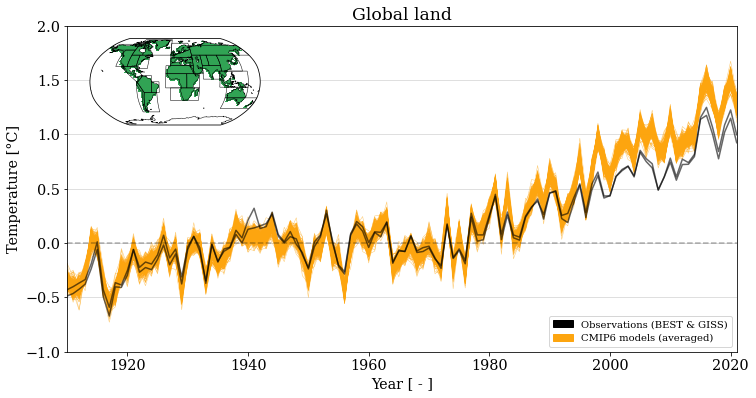

In [22]:
# time_all = pd.date_range('1870-01-01', '2022-01-01', freq='YS')
# time_all = time_all + pd.Timedelta(26, unit='w') - pd.Timedelta(1, unit='d')

time_emus = pd.date_range('1910-01-01', '2021-01-01', freq='YS')

fig=plt.figure(figsize=(12,6))

datasets = ["best", "giss"]

### set boundaries for y-axis
y_min = -1.0
y_max = 2.0
plt.ylim([y_min,y_max])

##create legend
obs_lg = mpatches.Patch(color="k", label="Observations (BEST & GISS)")
runs_lg = mpatches.Patch(color="#FDA50F", label="CMIP6 models (averaged)")

for run in np.arange(len(y_emu_gl)):
        plt.plot(time_emus, y_emu_gl[run], color='#FDA50F',lw=0.5,alpha=0.6)
#DB781B
#FDA50F
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann[dataset]['tas'], color="k", alpha=0.6)

plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')
leg = plt.legend(handles=[obs_lg,runs_lg], loc="lower right", prop={'size': 10})
plt.axhline(y=0, color='k', ls='--', alpha=0.3)
ax_sub = fig.add_axes([0.15, 0.65, 0.2, 0.2],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()

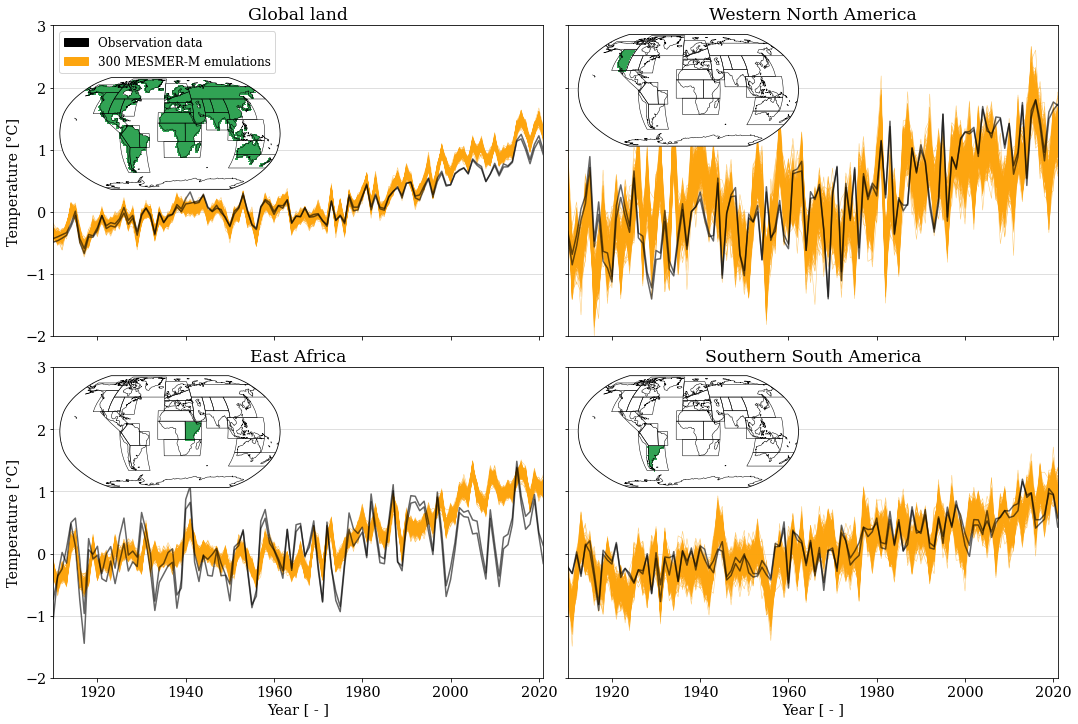

In [30]:
LST_all = {}
LST_all_WNA = {}
LST_all_EAF = {}
LST_all_SSA = {}

time_all = pd.date_range('1870-01-01', '2100-01-01', freq='YS')
time_all = time_all + pd.Timedelta(26, unit='w') - pd.Timedelta(1, unit='d')

fig=plt.figure(figsize=(18,12))
grid = plt.GridSpec(2, 2, wspace=0.05, hspace=0.1) # create a grid for the subplots

y_min = -2.0
y_max = 3.0

############ plot ax 1 (global land) ##########################
ax1 = plt.subplot(grid[0,0])
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim([y_min,y_max])

for run in np.arange(len(y_emu_gl)):
        plt.plot(time_emus, y_emu_gl[run], color='#FDA50F',lw=0.5,alpha=0.6)
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann[dataset]['tas'], color="k", alpha=0.6)
        
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land')
plt.ylabel('Temperature [°C]')

## create legend patches
obs_lg = mpatches.Patch(color="k", label="Observation data")
runs_lg = mpatches.Patch(color="#FDA50F", label="300 MESMER-M emulations")
leg = plt.legend(handles=[obs_lg,runs_lg], loc="upper left", prop={'size': 12})

ax_sub = fig.add_axes([0.13, 0.67, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)



############## plot ax2 (WNA) ###################################
ax2 = plt.subplot(grid[0,1])
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim([y_min,y_max])

for run in np.arange(len(y_emu_gl)):
        plt.plot(time_emus, y_emu_WNA[run], color='#FDA50F',lw=0.5,alpha=0.6)
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann_WNA[dataset]['tas'], color="k", alpha=0.6)
    
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Western North America')

ax_sub = fig.add_axes([0.53, 0.72, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_WNA, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

################# plot ax3 (EAF) ##################################
ax3 = plt.subplot(grid[1,0])
plt.ylim([y_min,y_max])

for run in np.arange(len(y_emu_gl)):
        plt.plot(time_emus, y_emu_EAF[run], color='#FDA50F',lw=0.5,alpha=0.6)
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann_EAF[dataset]['tas'], color="k", alpha=0.6)
    
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('East Africa')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')

ax_sub = fig.add_axes([0.13, 0.325, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_EAF, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

############## plot ax4 (SSA) ########################################
ax4 = plt.subplot(grid[1,1])
plt.ylim([y_min,y_max])
plt.xlabel('Year [ - ]')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())

for run in np.arange(len(y_emu_gl)):
        plt.plot(time_emus, y_emu_SSA[run], color='#FDA50F',lw=0.5,alpha=0.6)
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann_SSA[dataset]['tas'], color="k", alpha=0.6)
    
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Southern South America')
plt.xlabel('Year [ - ]')

ax_sub = fig.add_axes([0.53, 0.325, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_SSA, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()